# ML Zoomcamp 2023 - Homework #3

Name: Wong Chee Fah

Email: wongcheefah@gmail.com

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
len(df)

11914

In [3]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Data preparation

* Keep only these columns:
  * `Make`,
  * `Model`,
  * `Year`,
  * `Engine HP`,
  * `Engine Cylinders`,
  * `Transmission Type`,
  * `Vehicle Style`,
  * `highway MPG`,
  * `city mpg`
  * `MSRP`
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [4]:
df.drop(['Engine Fuel Type', 'Driven_Wheels', 'Number of Doors', 'Market Category', 'Vehicle Size', 'Popularity'], axis=1, inplace=True)

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [6]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [7]:
df.fillna(0, inplace=True)

In [8]:
df.isnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [9]:
df['above_average'] = (df['msrp'] > df['msrp'].mean()).astype(int)

In [10]:
df.drop('msrp', axis=1, inplace=True)

In [11]:
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['above_average'].values
y_val = df_val['above_average'].values
y_test = df_test['above_average'].values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [13]:
df_train.shape, df_val.shape, df_test.shape

((7148, 9), (2383, 9), (2383, 9))

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If the AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. The direction of the correlation can be changed by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [14]:
numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = list(filter(lambda i: i not in numerical, df_train.columns))

highest_auc = 0
highest_auc_feature = None

for feature in numerical:
    auc_score = roc_auc_score(y_train, df_train[feature])

    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[feature])
    
    print(feature, auc_score)
    
    if auc_score > highest_auc:
        highest_auc = auc_score
        highest_auc_feature = feature

print()
print(f'The numerical variable with the the highest AUC is {highest_auc_feature}.')

engine_hp 0.9171031265539011
engine_cylinders 0.766116490165669
highway_mpg 0.6330587871772013
city_mpg 0.6734244643245233

The numerical variable with the the highest AUC is engine_hp.


##### Ans: `engine_hp`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [15]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred), 3)

0.977

##### Ans: `0.979`

### Question 3: Precision and Recall

Compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [16]:
thresholds = np.linspace(0, 1, 101)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    precision = precision_score(y_val, y_pred >= threshold, zero_division=np.nan)
    recall = recall_score(y_val, y_pred >= threshold)
    precision_scores.append(precision)
    recall_scores.append(recall)

In [17]:
df_scores = pd.DataFrame({'Threshold':thresholds, 'Precision':precision_scores, 'Recall':recall_scores},)
df_scores

,Threshold,Precision,Recall
0,0.00,0.274444,1.000000
1,0.01,0.437290,0.996942
2,0.02,0.489106,0.995413
3,0.03,0.523733,0.995413
4,0.04,0.544845,0.993884
...,...,...,...
96,0.96,0.996094,0.389908
97,0.97,0.995798,0.362385
98,0.98,1.000000,0.322630
99,0.99,1.000000,0.276758


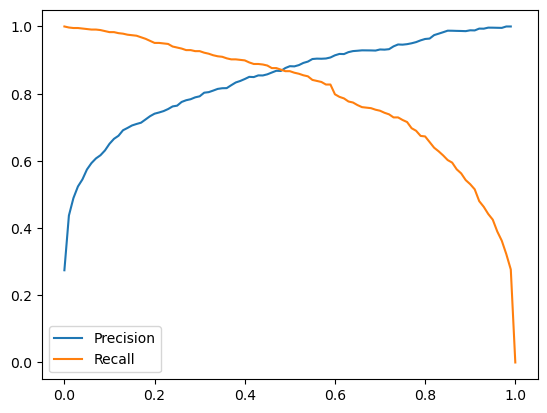

In [18]:
plt.plot(df_scores['Threshold'], df_scores['Precision'], label='Precision')
plt.plot(df_scores['Threshold'], df_scores['Recall'], label='Recall')
plt.legend()

##### Ans: `0.48`

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

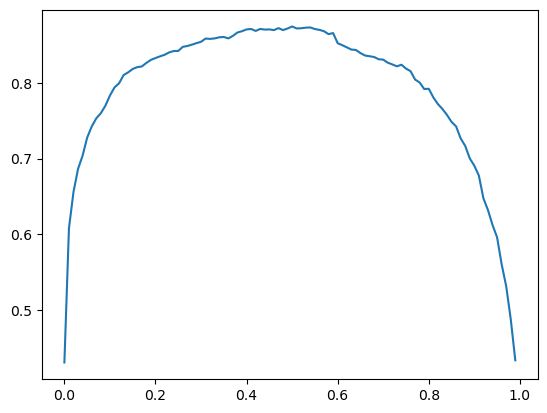

In [19]:
df_scores['F1'] = 2 * df_scores['Precision'] * df_scores['Recall'] / (df_scores['Precision'] + df_scores['Recall'])

plt.plot(df_scores['Threshold'], df_scores['F1'], label='F1')

In [20]:
max_f1_threshold = df_scores[df_scores['F1']==max(df_scores['F1'])]['Threshold']

print(f'Maximum F1 occurs at threshold value {max_f1_threshold.iloc[0]}.')

Maximum F1 occurs at threshold value 0.5.


### Ans: `0.52`

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [21]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [22]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['above_average'].values
    y_val = df_val['above_average'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('AUC scores')
print(scores)
print(f'AUC mean: {np.mean(scores):.3f}   AUC std dev: {np.std(scores):.3f}')


AUC scores
[0.9784891235596622, 0.9774843866825, 0.9849548268362055, 0.9772628408900786, 0.9776820401820402]
AUC mean: 0.979   AUC std dev: 0.003


### Ans: `0.003`

### Question 6: Hyperparemeter Tuning

Use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as before
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

In [24]:
max_mean_AUC = 0
best_C = None

print('  C  |  AUC  | Std Dev')

for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['above_average'].values
        y_val = df_val['above_average'].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_AUC = np.mean(scores)
    
    if mean_AUC > max_mean_AUC:
        max_mean_AUC = mean_AUC
        best_C = C
    
    print(f'{C:>4} | {mean_AUC:.3f} | {np.std(scores):.3f}')

print()
print(f'Maximum AUC occurs when C is {best_C}.')
    

  C  |  AUC  | Std Dev


0.01 | 0.952 | 0.002
 0.1 | 0.972 | 0.002
 0.5 | 0.979 | 0.001
  10 | 0.981 | 0.003

Maximum AUC occurs when C is 10.


### Ans: `10`